In [1]:
import sys
sys.path.append('/home/achint/Generative_Modelling/POISE_achint/')
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
import numpy as np

from data_loaders import MNIST_MNIST
from networks.encoders.MNIST_mlp import EncMNIST
# from networks.decoders.MNIST_mlp import DecMNIST
from networks.decoders.MNIST_pixel import DecMNIST
from networks.decoders.pixelcnn import PixelCNN

from utils.functions import train
from utils.functions import plotting
from utils.functions import load_checkpoint
from utils.functions import save_checkpoint

from model.poise_vae import POISE_VAE
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
MNIST_PATH = "/home/achint/datasets/MNIST/%s.pt"
PATH = "/home/achint/Generative_Modelling/saved_models/"
joint_dataset_train = MNIST_MNIST.MNIST_MNIST(mnist_pt_path=MNIST_PATH % 'training')
joint_dataset_test  = MNIST_MNIST.MNIST_MNIST(mnist_pt_path=MNIST_PATH % 'test')

In [3]:
batch_size = 128
train_loader = torch.utils.data.DataLoader(joint_dataset_train, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader  = torch.utils.data.DataLoader(joint_dataset_test, batch_size=batch_size, shuffle=True, drop_last=True)

In [4]:
lat1, lat2 = 20, 20
enc_mnist1 = EncMNIST(lat1).to(device)
enc_mnist2 = EncMNIST(lat2).to(device)
# dec_mnist1 = DecMNIST(lat1).to(device)
# dec_mnist2 = DecMNIST(lat2).to(device)

color_level = 256
dec_mnist1 = DecMNIST(PixelCNN(lat1, 1, color_level), color_level).to(device)
dec_mnist2 = DecMNIST(PixelCNN(lat2, 1, color_level), color_level).to(device)


In [5]:
vae = POISE_VAE([enc_mnist1, enc_mnist2], [dec_mnist1, dec_mnist2], latent_dims=[lat1, lat2], 
                    batch_size=batch_size,generate_mode= False).to(device)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

# vae.load_state_dict(torch.load(PATH))
# vae.eval()
vae, _, epoch = load_checkpoint(vae, load_path=os.path.join(PATH, 'training_170.pt'))


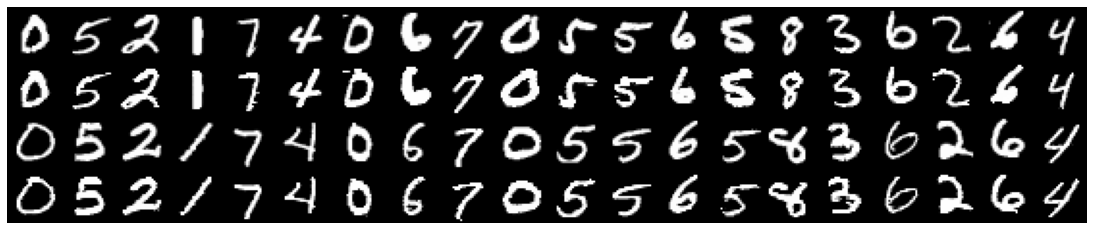

In [6]:
with torch.no_grad():
    for i, data in enumerate(test_loader):
        results = vae([data[0].to(device, dtype=torch.float32), data[1].to(device, dtype=torch.float32)],generate_mode= False)
        break
x_rec = [results['x_rec'][0].max(dim=1).indices.reshape(128,784),results['x_rec'][1].max(dim=1).indices.reshape(128,784)]
plotting(vae, data, x_rec)

In [13]:
epoch = 170
epochs = 30 + epoch
total_loss = []
kld_loss  = []
rec_loss  = []
for epoch in tqdm(range(epoch, epochs)):
    train(vae, train_loader, optimizer, epoch, generate_mode=False)
    if (epoch+1) % 5 == 0 and epoch > 0:
        save_checkpoint(vae, optimizer, os.path.join(PATH, 'training_%d.pt' % (epoch+1)), epoch+1) 
    with torch.no_grad():
        for i, data in enumerate(test_loader):
            results = vae([data[0].to(device, dtype=torch.float32), data[1].to(device, dtype=torch.float32)],generate_mode= False)            
            total_loss.append(results['total_loss'])
            kld_loss.append(results['KL_loss'])
            rec_loss.append(results['rec_losses'])
            print(total_loss)
            break

  3%|█▎                                       | 1/30 [08:54<4:18:14, 534.30s/it]

[tensor(143535.4219, device='cuda:0')]


  7%|██▋                                      | 2/30 [17:59<4:12:13, 540.47s/it]

[tensor(143535.4219, device='cuda:0'), tensor(148332.0625, device='cuda:0')]


 10%|████                                     | 3/30 [27:04<4:04:12, 542.70s/it]

[tensor(143535.4219, device='cuda:0'), tensor(148332.0625, device='cuda:0'), tensor(144500.2344, device='cuda:0')]


 13%|█████▍                                   | 4/30 [36:09<3:55:36, 543.70s/it]

[tensor(143535.4219, device='cuda:0'), tensor(148332.0625, device='cuda:0'), tensor(144500.2344, device='cuda:0'), tensor(145586.0469, device='cuda:0')]


 17%|██████▊                                  | 5/30 [45:14<3:46:46, 544.26s/it]

[tensor(143535.4219, device='cuda:0'), tensor(148332.0625, device='cuda:0'), tensor(144500.2344, device='cuda:0'), tensor(145586.0469, device='cuda:0'), tensor(147280., device='cuda:0')]


 20%|████████▏                                | 6/30 [54:19<3:37:44, 544.37s/it]

[tensor(143535.4219, device='cuda:0'), tensor(148332.0625, device='cuda:0'), tensor(144500.2344, device='cuda:0'), tensor(145586.0469, device='cuda:0'), tensor(147280., device='cuda:0'), tensor(147858.6094, device='cuda:0')]


 23%|█████████                              | 7/30 [1:03:24<3:28:43, 544.48s/it]

[tensor(143535.4219, device='cuda:0'), tensor(148332.0625, device='cuda:0'), tensor(144500.2344, device='cuda:0'), tensor(145586.0469, device='cuda:0'), tensor(147280., device='cuda:0'), tensor(147858.6094, device='cuda:0'), tensor(147040.8594, device='cuda:0')]


 27%|██████████▍                            | 8/30 [1:12:28<3:19:40, 544.55s/it]

[tensor(143535.4219, device='cuda:0'), tensor(148332.0625, device='cuda:0'), tensor(144500.2344, device='cuda:0'), tensor(145586.0469, device='cuda:0'), tensor(147280., device='cuda:0'), tensor(147858.6094, device='cuda:0'), tensor(147040.8594, device='cuda:0'), tensor(151991.4688, device='cuda:0')]


 30%|███████████▋                           | 9/30 [1:21:33<3:10:37, 544.65s/it]

[tensor(143535.4219, device='cuda:0'), tensor(148332.0625, device='cuda:0'), tensor(144500.2344, device='cuda:0'), tensor(145586.0469, device='cuda:0'), tensor(147280., device='cuda:0'), tensor(147858.6094, device='cuda:0'), tensor(147040.8594, device='cuda:0'), tensor(151991.4688, device='cuda:0'), tensor(146765.1719, device='cuda:0')]


 33%|████████████▋                         | 10/30 [1:30:38<3:01:34, 544.71s/it]

[tensor(143535.4219, device='cuda:0'), tensor(148332.0625, device='cuda:0'), tensor(144500.2344, device='cuda:0'), tensor(145586.0469, device='cuda:0'), tensor(147280., device='cuda:0'), tensor(147858.6094, device='cuda:0'), tensor(147040.8594, device='cuda:0'), tensor(151991.4688, device='cuda:0'), tensor(146765.1719, device='cuda:0'), tensor(150053.5469, device='cuda:0')]


 37%|█████████████▉                        | 11/30 [1:39:43<2:52:28, 544.67s/it]

[tensor(143535.4219, device='cuda:0'), tensor(148332.0625, device='cuda:0'), tensor(144500.2344, device='cuda:0'), tensor(145586.0469, device='cuda:0'), tensor(147280., device='cuda:0'), tensor(147858.6094, device='cuda:0'), tensor(147040.8594, device='cuda:0'), tensor(151991.4688, device='cuda:0'), tensor(146765.1719, device='cuda:0'), tensor(150053.5469, device='cuda:0'), tensor(145963.0469, device='cuda:0')]


 40%|███████████████▏                      | 12/30 [1:48:47<2:43:21, 544.55s/it]

[tensor(143535.4219, device='cuda:0'), tensor(148332.0625, device='cuda:0'), tensor(144500.2344, device='cuda:0'), tensor(145586.0469, device='cuda:0'), tensor(147280., device='cuda:0'), tensor(147858.6094, device='cuda:0'), tensor(147040.8594, device='cuda:0'), tensor(151991.4688, device='cuda:0'), tensor(146765.1719, device='cuda:0'), tensor(150053.5469, device='cuda:0'), tensor(145963.0469, device='cuda:0'), tensor(150302.8125, device='cuda:0')]


 43%|████████████████▍                     | 13/30 [1:57:51<2:34:16, 544.50s/it]

[tensor(143535.4219, device='cuda:0'), tensor(148332.0625, device='cuda:0'), tensor(144500.2344, device='cuda:0'), tensor(145586.0469, device='cuda:0'), tensor(147280., device='cuda:0'), tensor(147858.6094, device='cuda:0'), tensor(147040.8594, device='cuda:0'), tensor(151991.4688, device='cuda:0'), tensor(146765.1719, device='cuda:0'), tensor(150053.5469, device='cuda:0'), tensor(145963.0469, device='cuda:0'), tensor(150302.8125, device='cuda:0'), tensor(141178.3750, device='cuda:0')]


 47%|█████████████████▋                    | 14/30 [2:06:56<2:25:11, 544.48s/it]

[tensor(143535.4219, device='cuda:0'), tensor(148332.0625, device='cuda:0'), tensor(144500.2344, device='cuda:0'), tensor(145586.0469, device='cuda:0'), tensor(147280., device='cuda:0'), tensor(147858.6094, device='cuda:0'), tensor(147040.8594, device='cuda:0'), tensor(151991.4688, device='cuda:0'), tensor(146765.1719, device='cuda:0'), tensor(150053.5469, device='cuda:0'), tensor(145963.0469, device='cuda:0'), tensor(150302.8125, device='cuda:0'), tensor(141178.3750, device='cuda:0'), tensor(147436.3281, device='cuda:0')]


 50%|███████████████████                   | 15/30 [2:16:01<2:16:08, 544.58s/it]

[tensor(143535.4219, device='cuda:0'), tensor(148332.0625, device='cuda:0'), tensor(144500.2344, device='cuda:0'), tensor(145586.0469, device='cuda:0'), tensor(147280., device='cuda:0'), tensor(147858.6094, device='cuda:0'), tensor(147040.8594, device='cuda:0'), tensor(151991.4688, device='cuda:0'), tensor(146765.1719, device='cuda:0'), tensor(150053.5469, device='cuda:0'), tensor(145963.0469, device='cuda:0'), tensor(150302.8125, device='cuda:0'), tensor(141178.3750, device='cuda:0'), tensor(147436.3281, device='cuda:0'), tensor(149291.8594, device='cuda:0')]


 53%|████████████████████▎                 | 16/30 [2:25:05<2:07:04, 544.62s/it]

[tensor(143535.4219, device='cuda:0'), tensor(148332.0625, device='cuda:0'), tensor(144500.2344, device='cuda:0'), tensor(145586.0469, device='cuda:0'), tensor(147280., device='cuda:0'), tensor(147858.6094, device='cuda:0'), tensor(147040.8594, device='cuda:0'), tensor(151991.4688, device='cuda:0'), tensor(146765.1719, device='cuda:0'), tensor(150053.5469, device='cuda:0'), tensor(145963.0469, device='cuda:0'), tensor(150302.8125, device='cuda:0'), tensor(141178.3750, device='cuda:0'), tensor(147436.3281, device='cuda:0'), tensor(149291.8594, device='cuda:0'), tensor(160148.2344, device='cuda:0')]


 57%|█████████████████████▌                | 17/30 [2:34:10<1:58:01, 544.74s/it]

[tensor(143535.4219, device='cuda:0'), tensor(148332.0625, device='cuda:0'), tensor(144500.2344, device='cuda:0'), tensor(145586.0469, device='cuda:0'), tensor(147280., device='cuda:0'), tensor(147858.6094, device='cuda:0'), tensor(147040.8594, device='cuda:0'), tensor(151991.4688, device='cuda:0'), tensor(146765.1719, device='cuda:0'), tensor(150053.5469, device='cuda:0'), tensor(145963.0469, device='cuda:0'), tensor(150302.8125, device='cuda:0'), tensor(141178.3750, device='cuda:0'), tensor(147436.3281, device='cuda:0'), tensor(149291.8594, device='cuda:0'), tensor(160148.2344, device='cuda:0'), tensor(154186.9219, device='cuda:0')]


 60%|██████████████████████▊               | 18/30 [2:43:16<1:48:58, 544.89s/it]

[tensor(143535.4219, device='cuda:0'), tensor(148332.0625, device='cuda:0'), tensor(144500.2344, device='cuda:0'), tensor(145586.0469, device='cuda:0'), tensor(147280., device='cuda:0'), tensor(147858.6094, device='cuda:0'), tensor(147040.8594, device='cuda:0'), tensor(151991.4688, device='cuda:0'), tensor(146765.1719, device='cuda:0'), tensor(150053.5469, device='cuda:0'), tensor(145963.0469, device='cuda:0'), tensor(150302.8125, device='cuda:0'), tensor(141178.3750, device='cuda:0'), tensor(147436.3281, device='cuda:0'), tensor(149291.8594, device='cuda:0'), tensor(160148.2344, device='cuda:0'), tensor(154186.9219, device='cuda:0'), tensor(146561.9375, device='cuda:0')]


 63%|████████████████████████              | 19/30 [2:52:21<1:39:55, 545.04s/it]

[tensor(143535.4219, device='cuda:0'), tensor(148332.0625, device='cuda:0'), tensor(144500.2344, device='cuda:0'), tensor(145586.0469, device='cuda:0'), tensor(147280., device='cuda:0'), tensor(147858.6094, device='cuda:0'), tensor(147040.8594, device='cuda:0'), tensor(151991.4688, device='cuda:0'), tensor(146765.1719, device='cuda:0'), tensor(150053.5469, device='cuda:0'), tensor(145963.0469, device='cuda:0'), tensor(150302.8125, device='cuda:0'), tensor(141178.3750, device='cuda:0'), tensor(147436.3281, device='cuda:0'), tensor(149291.8594, device='cuda:0'), tensor(160148.2344, device='cuda:0'), tensor(154186.9219, device='cuda:0'), tensor(146561.9375, device='cuda:0'), tensor(145399.8125, device='cuda:0')]


 67%|█████████████████████████▎            | 20/30 [3:01:26<1:30:51, 545.18s/it]

[tensor(143535.4219, device='cuda:0'), tensor(148332.0625, device='cuda:0'), tensor(144500.2344, device='cuda:0'), tensor(145586.0469, device='cuda:0'), tensor(147280., device='cuda:0'), tensor(147858.6094, device='cuda:0'), tensor(147040.8594, device='cuda:0'), tensor(151991.4688, device='cuda:0'), tensor(146765.1719, device='cuda:0'), tensor(150053.5469, device='cuda:0'), tensor(145963.0469, device='cuda:0'), tensor(150302.8125, device='cuda:0'), tensor(141178.3750, device='cuda:0'), tensor(147436.3281, device='cuda:0'), tensor(149291.8594, device='cuda:0'), tensor(160148.2344, device='cuda:0'), tensor(154186.9219, device='cuda:0'), tensor(146561.9375, device='cuda:0'), tensor(145399.8125, device='cuda:0'), tensor(149576.6875, device='cuda:0')]


 70%|██████████████████████████▌           | 21/30 [3:10:32<1:21:46, 545.20s/it]

[tensor(143535.4219, device='cuda:0'), tensor(148332.0625, device='cuda:0'), tensor(144500.2344, device='cuda:0'), tensor(145586.0469, device='cuda:0'), tensor(147280., device='cuda:0'), tensor(147858.6094, device='cuda:0'), tensor(147040.8594, device='cuda:0'), tensor(151991.4688, device='cuda:0'), tensor(146765.1719, device='cuda:0'), tensor(150053.5469, device='cuda:0'), tensor(145963.0469, device='cuda:0'), tensor(150302.8125, device='cuda:0'), tensor(141178.3750, device='cuda:0'), tensor(147436.3281, device='cuda:0'), tensor(149291.8594, device='cuda:0'), tensor(160148.2344, device='cuda:0'), tensor(154186.9219, device='cuda:0'), tensor(146561.9375, device='cuda:0'), tensor(145399.8125, device='cuda:0'), tensor(149576.6875, device='cuda:0'), tensor(151868.1719, device='cuda:0')]


 73%|███████████████████████████▊          | 22/30 [3:19:37<1:12:41, 545.22s/it]

[tensor(143535.4219, device='cuda:0'), tensor(148332.0625, device='cuda:0'), tensor(144500.2344, device='cuda:0'), tensor(145586.0469, device='cuda:0'), tensor(147280., device='cuda:0'), tensor(147858.6094, device='cuda:0'), tensor(147040.8594, device='cuda:0'), tensor(151991.4688, device='cuda:0'), tensor(146765.1719, device='cuda:0'), tensor(150053.5469, device='cuda:0'), tensor(145963.0469, device='cuda:0'), tensor(150302.8125, device='cuda:0'), tensor(141178.3750, device='cuda:0'), tensor(147436.3281, device='cuda:0'), tensor(149291.8594, device='cuda:0'), tensor(160148.2344, device='cuda:0'), tensor(154186.9219, device='cuda:0'), tensor(146561.9375, device='cuda:0'), tensor(145399.8125, device='cuda:0'), tensor(149576.6875, device='cuda:0'), tensor(151868.1719, device='cuda:0'), tensor(158084.8281, device='cuda:0')]


 77%|█████████████████████████████▏        | 23/30 [3:28:42<1:03:36, 545.24s/it]

[tensor(143535.4219, device='cuda:0'), tensor(148332.0625, device='cuda:0'), tensor(144500.2344, device='cuda:0'), tensor(145586.0469, device='cuda:0'), tensor(147280., device='cuda:0'), tensor(147858.6094, device='cuda:0'), tensor(147040.8594, device='cuda:0'), tensor(151991.4688, device='cuda:0'), tensor(146765.1719, device='cuda:0'), tensor(150053.5469, device='cuda:0'), tensor(145963.0469, device='cuda:0'), tensor(150302.8125, device='cuda:0'), tensor(141178.3750, device='cuda:0'), tensor(147436.3281, device='cuda:0'), tensor(149291.8594, device='cuda:0'), tensor(160148.2344, device='cuda:0'), tensor(154186.9219, device='cuda:0'), tensor(146561.9375, device='cuda:0'), tensor(145399.8125, device='cuda:0'), tensor(149576.6875, device='cuda:0'), tensor(151868.1719, device='cuda:0'), tensor(158084.8281, device='cuda:0'), tensor(148381.5781, device='cuda:0')]


 80%|████████████████████████████████        | 24/30 [3:37:48<54:32, 545.36s/it]

[tensor(143535.4219, device='cuda:0'), tensor(148332.0625, device='cuda:0'), tensor(144500.2344, device='cuda:0'), tensor(145586.0469, device='cuda:0'), tensor(147280., device='cuda:0'), tensor(147858.6094, device='cuda:0'), tensor(147040.8594, device='cuda:0'), tensor(151991.4688, device='cuda:0'), tensor(146765.1719, device='cuda:0'), tensor(150053.5469, device='cuda:0'), tensor(145963.0469, device='cuda:0'), tensor(150302.8125, device='cuda:0'), tensor(141178.3750, device='cuda:0'), tensor(147436.3281, device='cuda:0'), tensor(149291.8594, device='cuda:0'), tensor(160148.2344, device='cuda:0'), tensor(154186.9219, device='cuda:0'), tensor(146561.9375, device='cuda:0'), tensor(145399.8125, device='cuda:0'), tensor(149576.6875, device='cuda:0'), tensor(151868.1719, device='cuda:0'), tensor(158084.8281, device='cuda:0'), tensor(148381.5781, device='cuda:0'), tensor(147660.7500, device='cuda:0')]


 83%|█████████████████████████████████▎      | 25/30 [3:46:54<45:27, 545.45s/it]

[tensor(143535.4219, device='cuda:0'), tensor(148332.0625, device='cuda:0'), tensor(144500.2344, device='cuda:0'), tensor(145586.0469, device='cuda:0'), tensor(147280., device='cuda:0'), tensor(147858.6094, device='cuda:0'), tensor(147040.8594, device='cuda:0'), tensor(151991.4688, device='cuda:0'), tensor(146765.1719, device='cuda:0'), tensor(150053.5469, device='cuda:0'), tensor(145963.0469, device='cuda:0'), tensor(150302.8125, device='cuda:0'), tensor(141178.3750, device='cuda:0'), tensor(147436.3281, device='cuda:0'), tensor(149291.8594, device='cuda:0'), tensor(160148.2344, device='cuda:0'), tensor(154186.9219, device='cuda:0'), tensor(146561.9375, device='cuda:0'), tensor(145399.8125, device='cuda:0'), tensor(149576.6875, device='cuda:0'), tensor(151868.1719, device='cuda:0'), tensor(158084.8281, device='cuda:0'), tensor(148381.5781, device='cuda:0'), tensor(147660.7500, device='cuda:0'), tensor(150602.3906, device='cuda:0')]


 87%|██████████████████████████████████▋     | 26/30 [3:55:59<36:21, 545.43s/it]

[tensor(143535.4219, device='cuda:0'), tensor(148332.0625, device='cuda:0'), tensor(144500.2344, device='cuda:0'), tensor(145586.0469, device='cuda:0'), tensor(147280., device='cuda:0'), tensor(147858.6094, device='cuda:0'), tensor(147040.8594, device='cuda:0'), tensor(151991.4688, device='cuda:0'), tensor(146765.1719, device='cuda:0'), tensor(150053.5469, device='cuda:0'), tensor(145963.0469, device='cuda:0'), tensor(150302.8125, device='cuda:0'), tensor(141178.3750, device='cuda:0'), tensor(147436.3281, device='cuda:0'), tensor(149291.8594, device='cuda:0'), tensor(160148.2344, device='cuda:0'), tensor(154186.9219, device='cuda:0'), tensor(146561.9375, device='cuda:0'), tensor(145399.8125, device='cuda:0'), tensor(149576.6875, device='cuda:0'), tensor(151868.1719, device='cuda:0'), tensor(158084.8281, device='cuda:0'), tensor(148381.5781, device='cuda:0'), tensor(147660.7500, device='cuda:0'), tensor(150602.3906, device='cuda:0'), tensor(144352.0469, device='cuda:0')]


 87%|██████████████████████████████████▋     | 26/30 [3:57:13<36:29, 547.45s/it]


KeyboardInterrupt: 

## Reconstruction

In [ ]:
# plotting(vae, data, results['x_rec'])
with torch.no_grad():
    for i, data in enumerate(test_loader):
        results = vae([data[0].to(device, dtype=torch.float32), data[1].to(device, dtype=torch.float32)],generate_mode= False)
        break
x_rec = [results['x_rec'][0].max(dim=1).indices.reshape(128,784),results['x_rec'][1].max(dim=1).indices.reshape(128,784)]
plotting(vae, data, x_rec)


In [ ]:
gfgh

## Cross Generation

In [7]:
input_data1 = [data[0].to(device, dtype=torch.float32), None]
input_data2 = [None, data[1].to(device, dtype=torch.float32)]
with torch.no_grad():
    for i, data in enumerate(test_loader):
        results1 = vae(input_data1,generate_mode= True)
        results2 = vae(input_data2,generate_mode= True)
        break
input_data1[1] = torch.zeros_like(data[1]).to(device)
input_data2[0] = torch.zeros_like(data[0]).to(device)


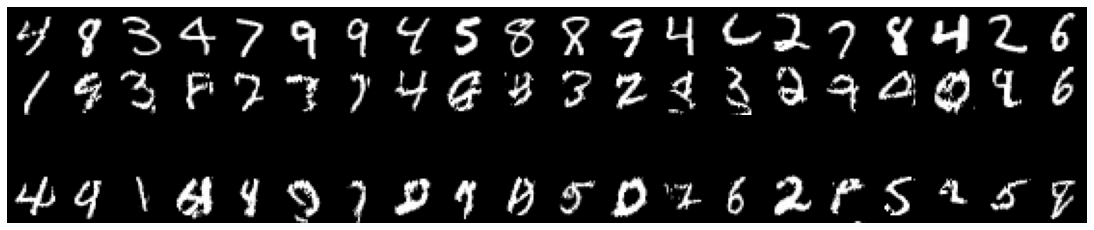

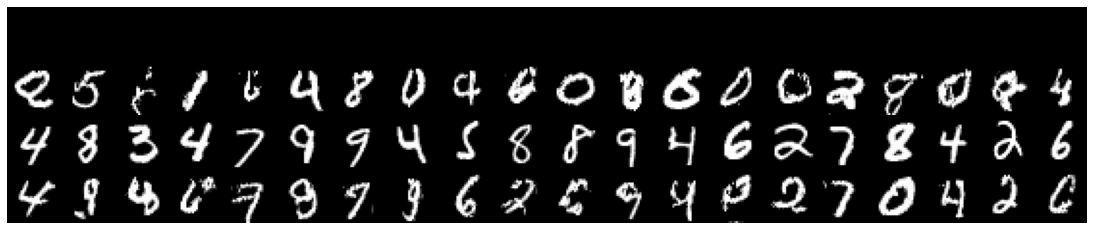

In [8]:
a = [results1['x_rec'][0],results1['x_rec'][1].flatten(-3,-1)]
b = [results2['x_rec'][0].flatten(-3,-1),results2['x_rec'][1]]

# plotting(vae, input_data1,results1['x_rec'])
# plotting(vae, input_data2,results2['x_rec'])
plotting(vae, input_data1,a)
plotting(vae, input_data2,b)

## Joint Generation

In [9]:
input_data = [None, None]
with torch.no_grad():
    for i, data in enumerate(test_loader):
        results = vae(input_data,generate_mode= True)
        break
input_data[0] = torch.zeros_like(data[0]).to(device)
input_data[1] = torch.zeros_like(data[1]).to(device)

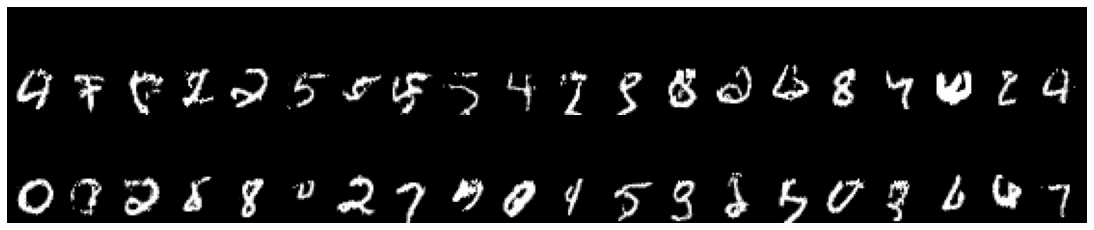

In [10]:
a=[results['x_rec'][0].flatten(-3,-1),results['x_rec'][1].flatten(-3,-1)]
plotting(vae, input_data,a)
# plotting(vae, input_data,results['x_rec'])

In [ ]:
# PATH = "/home/achint/Generative_Modelling/POISE_achint/saved_models/MNIST_MNIST_PIXEL_uncoupled.pt"
# torch.save(vae.state_dict(), PATH)


## UMAP

In [7]:
z1_tot = []
z2_tot = []
label_tot = []
with torch.no_grad():
    for i, data in enumerate(test_loader):
        label = data[-1].detach().cpu().numpy()
        data = [data[0].to(device, dtype=torch.float32), data[1].to(device, dtype=torch.float32)]
        results = vae(data,generate_mode= False)
        z1_tot.append(results['z_posteriors'][0].detach().cpu().numpy())
        z2_tot.append(results['z_posteriors'][1].detach().cpu().numpy()) 
        label_tot.append(label)
z1_tot = np.vstack(z1_tot)
z2_tot = np.vstack(z2_tot)
label_tot = np.hstack(label_tot)

In [8]:
import umap
reducer = umap.UMAP(min_dist=0.01, n_neighbors=50)
embedding_mod_1 = reducer.fit_transform(z1_tot)  
embedding_mod_2 = reducer.fit_transform(z2_tot)                

In [17]:
np.shape(umap_x_1)

NameError: name 'umap_x_1' is not defined

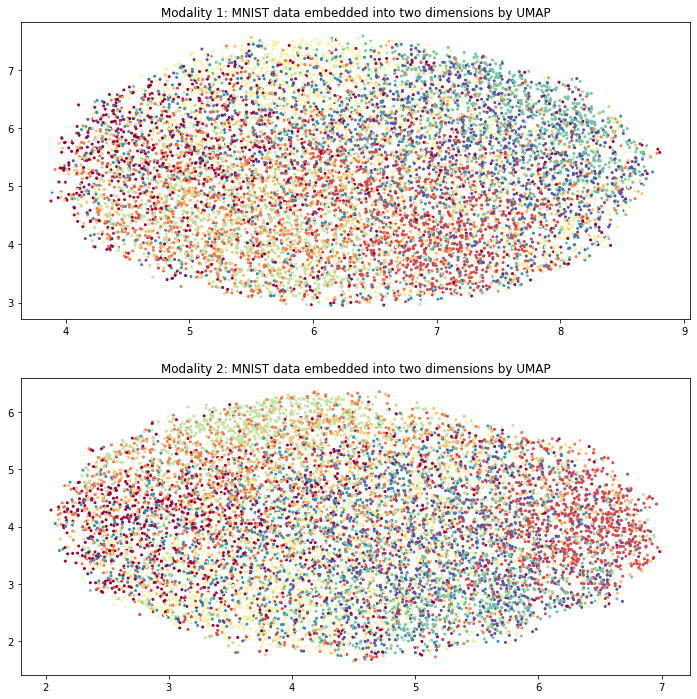

In [9]:
color     = label_tot       
umap_x_1 = []
umap_y_1 = []
umap_x_2 = []
umap_y_2 = []
for i, data in enumerate(test_loader):
    for j in range(batch_size):
        umap_x_1.append(embedding_mod_1[i*batch_size+j][0])
        umap_y_1.append(embedding_mod_1[i*batch_size+j][1])
        umap_x_2.append(embedding_mod_2[i*batch_size+j][0])
        umap_y_2.append(embedding_mod_2[i*batch_size+j][1])

fig = plt.figure(figsize=(12, 12))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
ax1.scatter(umap_x_1,umap_y_1,c=color, cmap="Spectral", s=4)
ax1.title.set_text("Modality 1: MNIST data embedded into two dimensions by UMAP")
ax1.set_facecolor('white')
# cbar      = fig.colorbar(boundaries=np.arange(11)-0.5)
# cbar.set_ticks(np.arange(10))
# cbar.set_ticklabels(np.arange(10))

ax2.scatter(umap_x_2,umap_y_2,c=color, cmap="Spectral", s=4)
ax2.title.set_text("Modality 2: MNIST data embedded into two dimensions by UMAP")
ax2.set_facecolor('white')


plt.show() 

## Error

NameError: name 'total_loss' is not defined

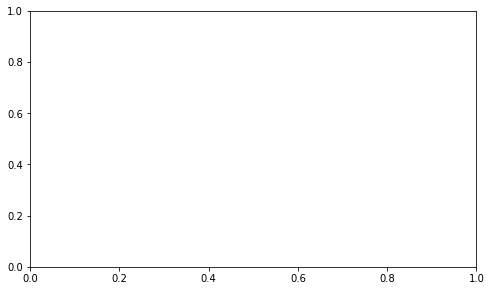

In [15]:
fig = plt.figure(figsize=(8, 16))
ax1 = fig.add_subplot(311)
plt.plot(list(map(lambda x: x.item(), total_loss)))
plt.title('Total loss')
# plt.tick_params('x', labelsize=6)

# share x only
ax2 = fig.add_subplot(312, sharex=ax1)
plt.plot(list(map(lambda x: x.item(), kld_loss)))
plt.title('KLD loss')
# make these tick labels invisible
plt.tick_params('x', labelbottom=False)

# share x and y
ax3 = fig.add_subplot(313, sharex=ax1, sharey=ax1)
plt.title('Rec loss')

plt.plot(list(map(lambda x: x.item(), rec_loss)))
# plt.xlim(0.01, 5.0)
plt.subplots_adjust(wspace=1.0, 
                    hspace=0.2)
plt.show()

## PCA

In [25]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents_1 = pca.fit_transform(z1_tot)
principalComponents_2 = pca.fit_transform(z2_tot)

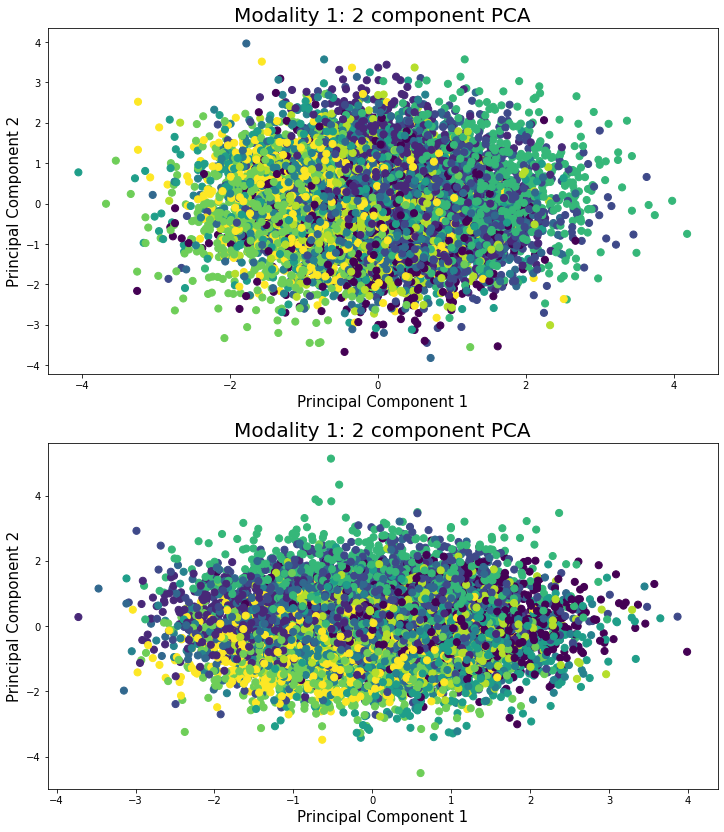

In [31]:
fig = plt.figure(figsize = (12,14))
ax1 = fig.add_subplot(211) 
ax1.set_xlabel('Principal Component 1', fontsize = 15)
ax1.set_ylabel('Principal Component 2', fontsize = 15)
ax1.set_title('Modality 1: 2 component PCA', fontsize = 20)
ax1.scatter(principalComponents_1[:,0],principalComponents_1[:,1],c= color, s =50)

ax2 = fig.add_subplot(2,1,2) 
ax2.set_xlabel('Principal Component 1', fontsize = 15)
ax2.set_ylabel('Principal Component 2', fontsize = 15)
ax2.set_title('Modality 1: 2 component PCA', fontsize = 20)
ax2.scatter(principalComponents_2[:,0],principalComponents_2[:,1],c= color, s =50)